# Initializing model

In [17]:
from transformers import AutoTokenizer
from transformers import BertTokenizer
import torch
import os
import matplotlib.pyplot as plt

In [2]:
model = torch.load("/home/hamvir/NLP/Project/dataset/bert/results_2000/model.pt", map_location=torch.device('cpu'))  # You can specify the device (e.g., 'cuda:0') if using GPU

In [ ]:
model.eval()

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Removing Gender Bias

## Sentence 1

In [5]:
x = tokenizer("My wife said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']  # Tokenizing

In [226]:
contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)

### without control

In [227]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [228]:
y.shape

torch.Size([1, 7, 30522])

In [229]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'what my wife said that. [SEP]'

In [230]:
y = y[:,-2,:] # (1, 5, 50264) -> (1, 50264)

In [231]:
he_token = tokenizer.encode(" he", add_special_tokens=False)
she_token = tokenizer.encode(" she", add_special_tokens=False)

In [232]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [233]:
p_he_she

tensor([0.9085], grad_fn=<ExpBackward0>)

### with control

In [234]:
weights= torch.ones_like(contextualization)
weights[:,10,:,:]= 0  # making the weight corresponding to 10th senses zero

In [235]:
contextualization=contextualization*weights

In [236]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [237]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'http my wife said that.,'

In [238]:
y = y[:,-2,:] # (1, 5, 50264) -> (1, 50264)

In [239]:
he_token = tokenizer.encode(" he", add_special_tokens=False)
she_token = tokenizer.encode(" she", add_special_tokens=False)

In [240]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [241]:
p_he_she

tensor([0.9521], grad_fn=<ExpBackward0>)

## Sentence 2

In [258]:
x = tokenizer(" The CEO believes that "+tokenizer.mask_token,return_tensors='pt')['input_ids']  # Tokenizing

In [259]:
contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)

### without control

In [260]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [261]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'what the ceo believes that. [SEP]'

In [262]:
y = y[:,-2,:] # (1, 5, 50264) -> (1, 50264)

In [263]:
he_token = tokenizer.encode("he", add_special_tokens=False)
she_token = tokenizer.encode("she", add_special_tokens=False)

In [264]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [265]:
p_he_she

tensor([14.0413], grad_fn=<ExpBackward0>)

### with control

In [266]:
weights= torch.ones_like(contextualization)
weights[:,10,:,:]= 0  # making the weight corresponding to 10th senses zero

In [267]:
contextualization=contextualization*weights

In [268]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [269]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'what the ceo believes that said [SEP]'

In [270]:
y = y[:,-2,:] # (1, 5, 50264) -> (1, 50264)

In [271]:
he_token = tokenizer.encode("he", add_special_tokens=False)
she_token = tokenizer.encode("she", add_special_tokens=False)

In [272]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [273]:
p_he_she

tensor([8.3902], grad_fn=<ExpBackward0>)

# control vs probability

## Sentence 1

In [372]:
def prob_ratio(x,p):
    contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
    contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)
    weights= torch.ones_like(contextualization)
    weights[:,1,:,:]= p  # making the weight corresponding to 10th senses zero
    contextualization=contextualization*weights
    y = model.run_with_custom_contextualization(x,contextualization).logits.detach()
    y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)
    he_token = tokenizer.encode("he", add_special_tokens=False)
    she_token = tokenizer.encode("she", add_special_tokens=False)
    p_he_she = torch.exp(y[0,he_token]-y[0,she_token])
    return p_he_she.item()

In [373]:
x = tokenizer("My husband said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

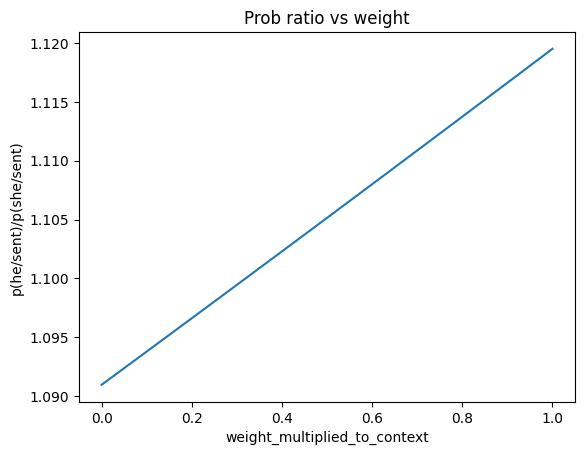

In [374]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [375]:
x = tokenizer(" My wife said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

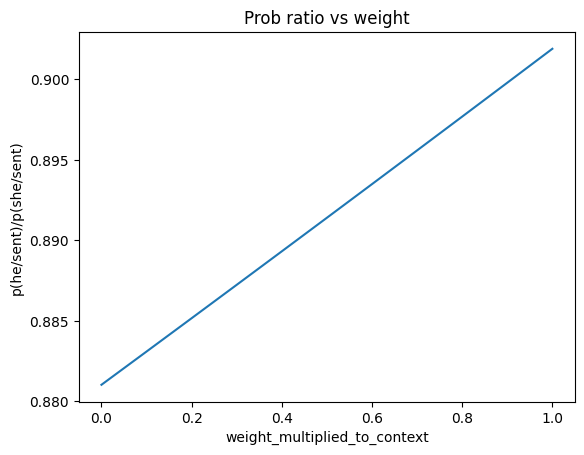

In [376]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [377]:
x = tokenizer(" The CEO of the company said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

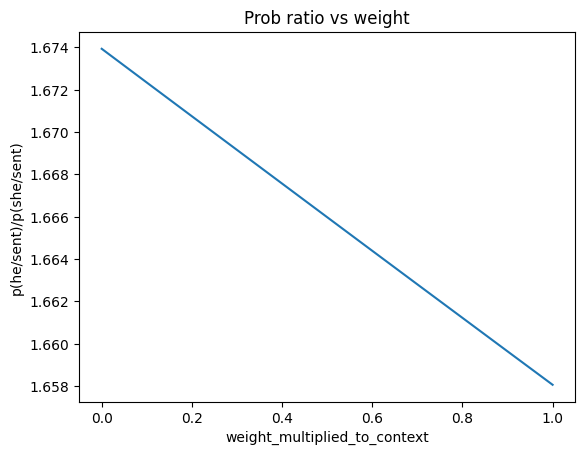

In [378]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [379]:
x = tokenizer(" The Nurse said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

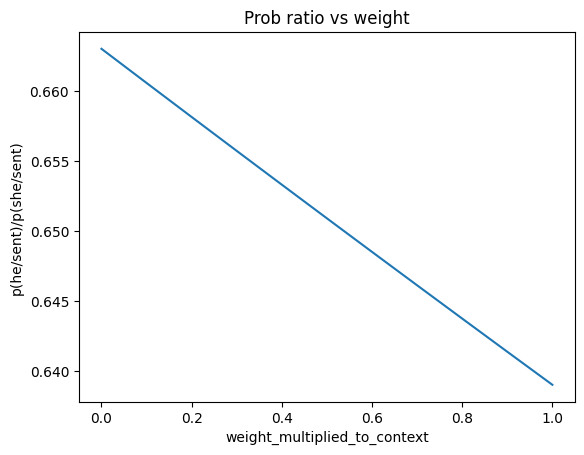

In [380]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [381]:
x = tokenizer(" The Doctor said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

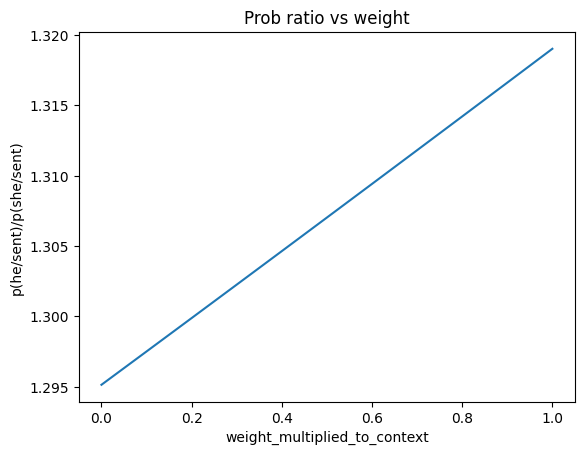

In [382]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [383]:
x = tokenizer("The teacher said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

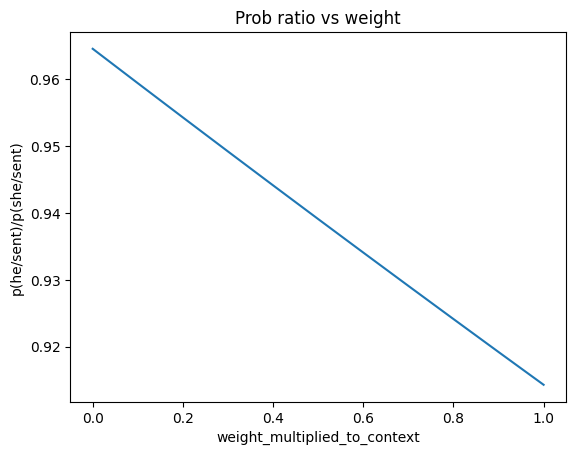

In [384]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [385]:
x = tokenizer(" The developer said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

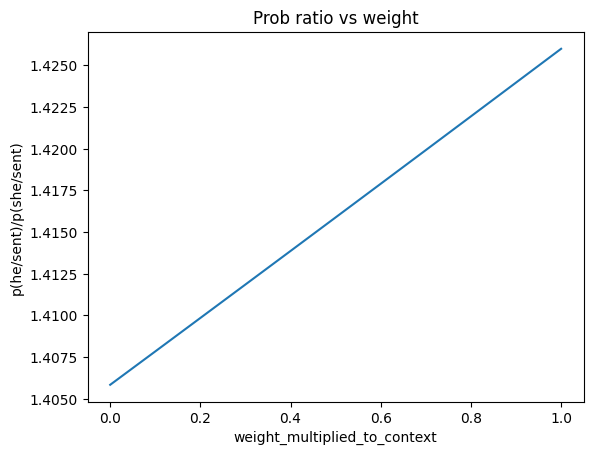

In [386]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [387]:
x = tokenizer("The pilot said that "+tokenizer.mask_token,return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

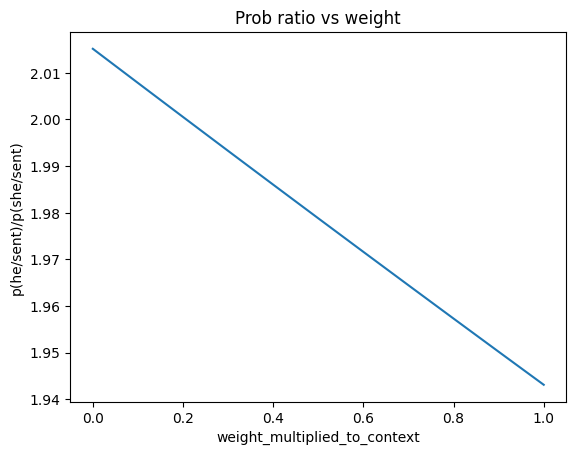

In [388]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()